In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=09fce43c0835407c6935078bcf474f87e41a0cd295a8700a6c401e77062f4eec
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [3]:
import wandb
wandb.login()
#ec0fa02abb6680e2e41f9e94ffb3c3a636ca9007

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
%cd  '/content/drive/MyDrive/AI Project/Dataset1/'
# # /content/drive/MyDrive/AI Project/Dataset1/PlantVillage

/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1


In [5]:
%pwd

'/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1'

In [6]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator 

In [7]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage'
width=256
height=256
depth=3
batch_size = 128

In [8]:
train_config = {"EPOCHS" : 10,
"INIT_LR" : 1e-3,
"BS" : 32,
"default_image_size" : tuple((256, 256)),
"image_size" : 0,
"directory_root" : '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage',
"width":256,
"height":256,
"depth":3,
"batch_size" : 128}

In [9]:
run = wandb.init(project="shuffleNet2", config=train_config)

wandb: Currently logged in as: shiransilva143 (shiranaai). Use `wandb login --relogin` to force relogin


In [10]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [11]:


data_path = '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage_15 classes/'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [12]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.3, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.7, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [13]:
print(len(dataset['train']))
print(len(dataset['valid']))
print(len(dataset['test']))

14411
1853
4324


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=False,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train/valid/test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  train/valid/test : 113 / 15 / 34


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
#class distribution test

count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)

v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

[ 707. 1012.  682.  633.  121. 1510.  729. 1332.  678. 1246. 1197.  994.
 2198.  268. 1104.]
[ 82. 144.  98.  94.  19. 197.  89. 168.  74. 152. 146. 122. 301.  27.
 140.]


In [ ]:
# imgtest = None
# for images, labels in dataloaders['train']:  
#     print(images)
#     print(labels)
#     imgtest = images[3]
#     print(imgtest.shape)
#     break

# imgtest = imgtest.numpy()
# imgtest = np.moveaxis(imgtest, 0, -1)
# imshow(imgtest)

In [19]:
# modeling
from torchvision import models
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.shufflenet_v2_x2_0(weights = None,num_classes=classes,progress=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [20]:
dataloaders['train'] = DeviceDataLoader(dataloaders['train'], device)
dataloaders['valid'] = DeviceDataLoader(dataloaders['valid'], device)
dataloaders['test'] = DeviceDataLoader(dataloaders['test'], device)

In [21]:
model = to_device(PlantDiseaseModel(classes=15), device) 
# model = PlantDiseaseModel(classes=len(count))
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
model


PlantDiseaseModel(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [ ]:
# # defining the model and moving it to the GPU
# model = to_device(PlantDiseaseModel(len(train.classes)), device) 
# model

In [22]:
device


device(type='cuda')

In [23]:
num_epochs = 10
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0
dev = device
since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    wandb.log({'epoch':(epoch+1)/num_epochs,'training_loss': trn_loss/batch_num['train'],'validation_loss': val_loss/batch_num['valid']})
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet2/best_model.pt')
print("model saved")

epoch: 1/10 | trn loss: 2.7044 | val loss: 2.6966 | 1m 23s elapsed
best model updated-epoch: 1 | val_accuracy: 7.6472
epoch: 2/10 | trn loss: 2.6856 | val loss: 2.6698 | 2m 48s elapsed
epoch: 3/10 | trn loss: 2.6659 | val loss: 2.6539 | 4m 13s elapsed
epoch: 4/10 | trn loss: 2.6573 | val loss: 2.6474 | 5m 37s elapsed
epoch: 5/10 | trn loss: 2.6475 | val loss: 2.6370 | 7m 2s elapsed
best model updated-epoch: 5 | val_accuracy: 8.3732
epoch: 6/10 | trn loss: 2.6378 | val loss: 2.6264 | 8m 28s elapsed
best model updated-epoch: 6 | val_accuracy: 8.9540
epoch: 7/10 | trn loss: 2.6296 | val loss: 2.6190 | 9m 51s elapsed
best model updated-epoch: 7 | val_accuracy: 9.0508
epoch: 8/10 | trn loss: 2.6235 | val loss: 2.6139 | 11m 17s elapsed
best model updated-epoch: 8 | val_accuracy: 9.2928
epoch: 9/10 | trn loss: 2.6189 | val loss: 2.6093 | 12m 44s elapsed
best model updated-epoch: 9 | val_accuracy: 9.5348
epoch: 10/10 | trn loss: 2.6144 | val loss: 2.6042 | 14m 9s elapsed
best model updated-epo

In [24]:
!pwd

/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1


In [25]:
print(trn_loss_list)

[2.7044438872717125, 2.685559639888527, 2.665879724300013, 2.657318541433959, 2.6474593550758025, 2.6377764275643676, 2.629578754965183, 2.6234780560552546, 2.6188521216400957, 2.614394428455724]


In [26]:
trn_acc_list = torch.randn(10)
trn_acc_list.tolist()

[-0.0908467248082161,
 1.7698873281478882,
 -0.025683704763650894,
 0.41617605090141296,
 0.07524027675390244,
 -0.17495152354240417,
 -0.5382640957832336,
 0.6184176206588745,
 -0.8010512590408325,
 -0.2182915061712265]

In [27]:
val_acc_list = torch.randn(10)
val_acc_list.tolist()

[-0.8337987065315247,
 0.9582836031913757,
 -0.673006534576416,
 -0.660758376121521,
 0.26803532242774963,
 1.1274722814559937,
 1.6537195444107056,
 -0.3325802683830261,
 1.3018476963043213,
 1.0635809898376465]

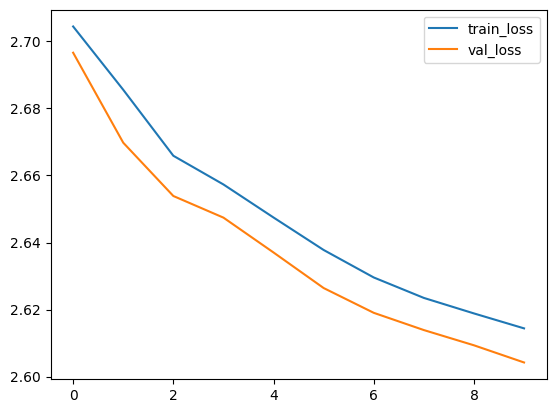

In [28]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

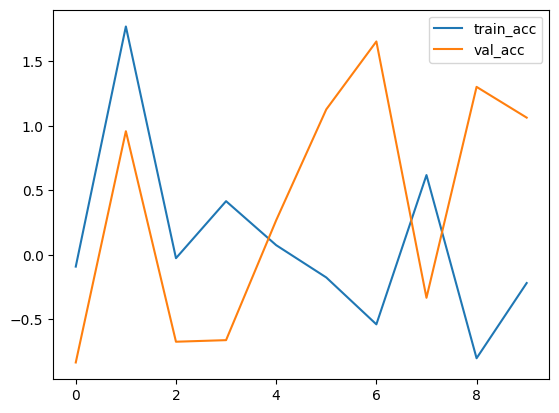

In [29]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [ ]:
# best_model = PlantDiseaseModel()
# best_model.load_state_dict(torch.load('best_model.pt'))


In [30]:
%pwd

'/content/drive/.shortcut-targets-by-id/1beS3uwOpI8c8fbKBFTXm97pjU-hHLvVr/AI Project/Dataset1'

In [31]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model = best_model.to(device)
# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in dataloaders['test']:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

Precision: 0.0259, Recall: 0.1030, F-score: 0.0413
Confusion matrix:
 [[  0   0   0   0   0   0   0   0   0 164   0   0  54   0   0]
 [  0   0   0   0   0   0   0   0   0 191   0   0 131   0   0]
 [  0   0   0   0   0   0   0   0   0 220   0   0  10   0   0]
 [  0   0   0   0   0   0   0   0   0  29   0   0 154   0   0]
 [  0   0   0   0   0   0   0   0   0  11   0   0  11   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 420   0   0]
 [  0   0   0   0   0   0   0   0   0  67   0   0 115   0   0]
 [  0   0   0   0   0   0   0   0   0 122   0   0 287   0   0]
 [  0   0   0   0   0   0   0   0   0  86   0   0 114   0   0]
 [  0   0   0   0   0   0   0   0   0 211   0   0 162   0   0]
 [  0   0   0   0   0   0   0   0   0 152   0   0 181   0   0]
 [  0   0   0   0   0   0   0   0   0 180   0   0 108   0   0]
 [  0   0   0   0   0   0   0   0   0  15   0   0 694   0   0]
 [  0   0   0   0   0   0   0   0   0  32   0   0  46   0   0]
 [  0   0   0   0   0   0   0   0   0 209   0   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


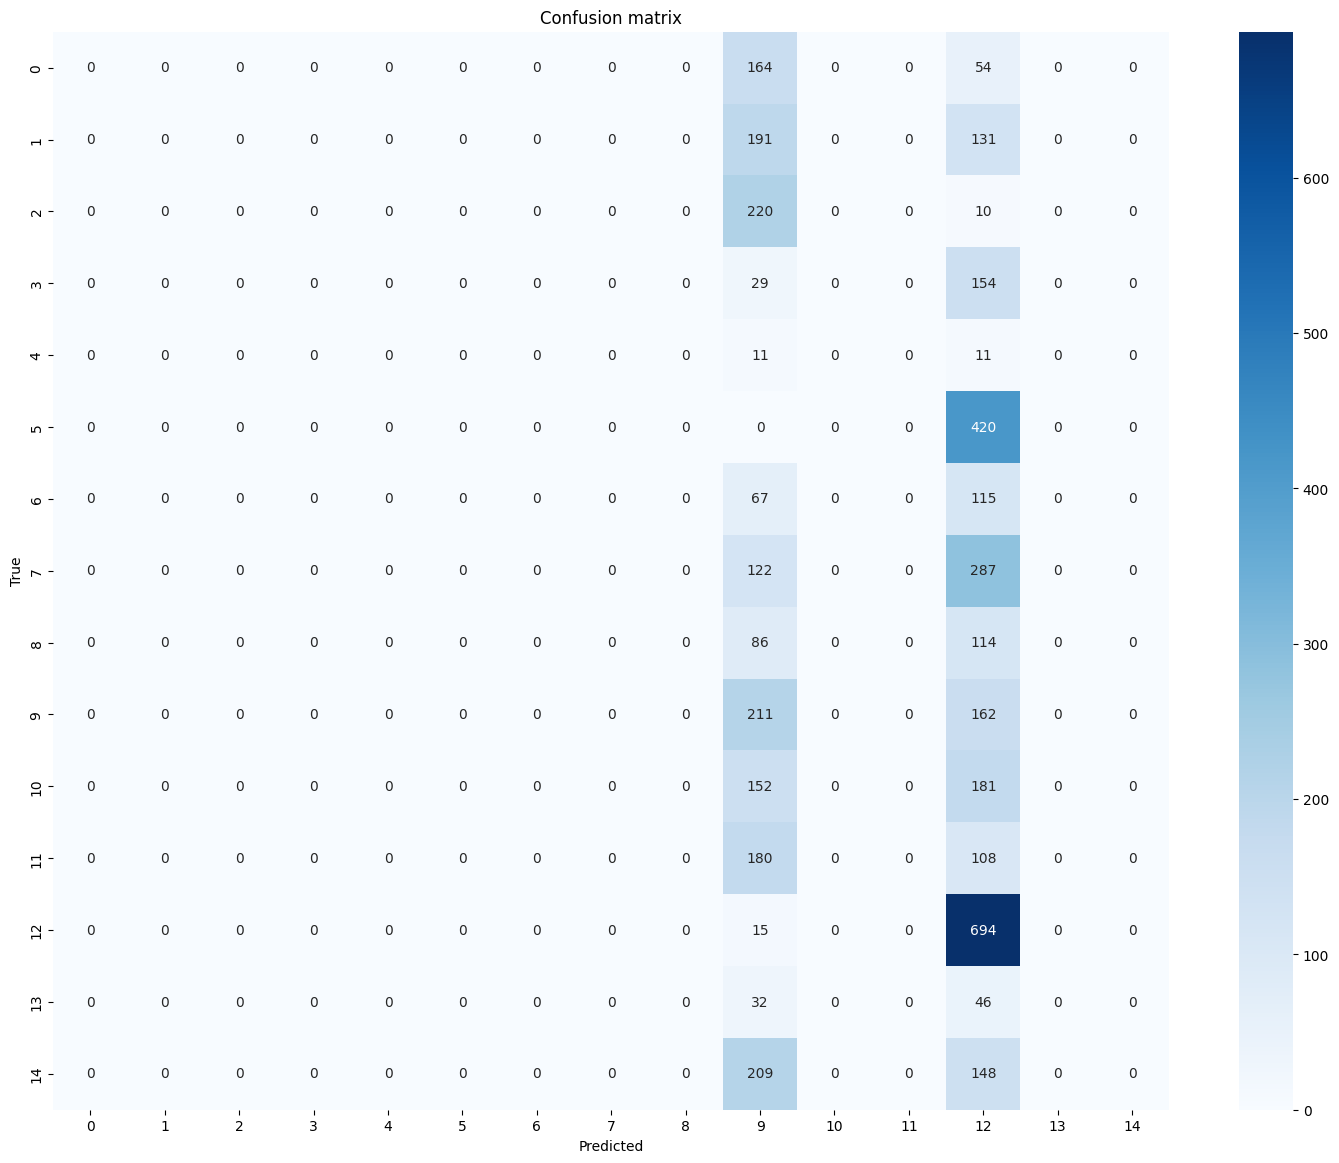

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
